### Edgar Moises Hernandez-Gonzalez
#### 27/02/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-3D, CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Espectrogramas STFFT (4D)
##### 2 canales C3 y C4
##### 5 ejecuciones independientes

#### CNN-3D
##### Sujeto 1
##### Accuracy = 54.51%
##### Kappa = 0.3935

#### CNN-3D BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 52.43%
##### Kappa = 0.3657

#### CNN-2D + LSTM BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 52.78%
##### Kappa = 0.3704

#### CNN-2D + GRU BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 50.35%
##### Kappa = 0.3380

#### ConvLSTM2D BN
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, MaxPool3D, Flatten, Dense, Dropout,
                                     TimeDistributed, Conv2D, MaxPool2D, LSTM,
                                     GRU, ConvLSTM2D, BatchNormalization,
                                     Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 7000:8000]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 11000:12000]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 7000:8000]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 11000:12000]

In [ ]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
x_train = np.concatenate((c3_train, c4_train), axis=1)
x_test = np.concatenate((c3_test, c4_test), axis=1)

In [ ]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 2000)
(288, 2000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#2 canales C3 y C4
def espectrogramas(data):
  fs = 250
  datos = np.zeros((288,2,24,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      datos[i,j] = Sxx[8:32, :]
  return datos

In [ ]:
#llamar a espectrogramas(data)
x_train = espectrogramas(x_train)
x_test = espectrogramas(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 2, 24, 4)
(288, 2, 24, 4)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

76.44927548656395
56.146734378722755
1.3045029327757274e-05
3.770593846744206e-06


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.59725994
0.43864638
1.0191429e-07
2.9457764e-08


In [ ]:
#convertir de 4D a 5D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))

print(x_train.shape)
print(x_test.shape)

(288, 2, 24, 4, 1)
(288, 2, 24, 4, 1)


In [ ]:
'''def CNN_3D():
  model = Sequential()
  model.add(Conv3D(128, (1,3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [ ]:
'''def CNN_3D_BN():
    model = Sequential()
    model.add(Conv3D(128, (1,3,3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model'''

"def CNN_3D_BN():\n    model = Sequential()\n    model.add(Conv3D(128, (1,3,3), padding='same',\n                     input_shape=x_train.shape[1:]))\n    model.add(BatchNormalization())\n    model.add(Activation('relu'))\n    model.add(MaxPool3D((1,2,2)))\n    model.add(Conv3D(128, (1,3,3), padding='same'))\n    model.add(BatchNormalization())\n    model.add(Activation('relu'))\n    model.add(MaxPool3D((1,2,2)))\n    model.add(Conv3D(128, (1,3,3), padding='same'))\n    model.add(BatchNormalization())\n    model.add(Activation('relu'))\n    model.add(Flatten())\n    model.add(Dense(64))\n    model.add(BatchNormalization())\n    model.add(Activation('relu'))\n    model.add(Dense(n_classes, activation='softmax'))\n    \n    optimizer = Adam(lr=1e-5)\n    model.compile(optimizer=optimizer,\n                  loss='sparse_categorical_crossentropy',\n                  metrics=['accuracy'])\n    return model"

In [ ]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [ ]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

"def CNN_2D_LSTM_TD_BN():\n  model = Sequential()\n  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),\n                            input_shape=x_train.shape[1:]))\n  model.add(TimeDistributed(BatchNormalization()))\n  model.add(TimeDistributed(Activation('relu')))\n  model.add(TimeDistributed(MaxPool2D((2,2))))\n  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same')))\n  model.add(TimeDistributed(BatchNormalization()))\n  model.add(TimeDistributed(Activation('relu')))\n  model.add(TimeDistributed(Flatten()))\n  model.add(LSTM(32))\n  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh\n  model.add(Dense(n_classes, activation='softmax'))\n    \n  optimizer = Adam(lr=1e-5)\n  model.compile(optimizer=optimizer,\n                loss='sparse_categorical_crossentropy',\n                metrics=['accuracy'])\n  return model"

In [ ]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(4, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(16))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [ ]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion va antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [ ]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(64, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
'''def Conv_LSTM_2D_BN():
    model = Sequential()
    model.add(ConvLSTM2D(64, (3,3), padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model'''

Iteration: 1
288/288 - 0s - loss: 1.1412 - acc: 0.4896
kappa:  0.3194444444444444
f1: 0.4892857142857142
confusion matrix:
 [[30 26 11  5]
 [24 41  5  2]
 [ 8  7 33 24]
 [ 6  2 27 37]]


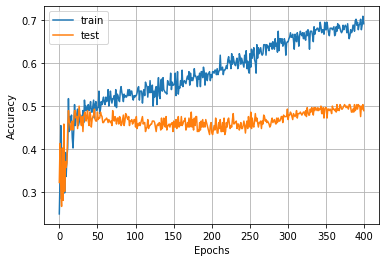

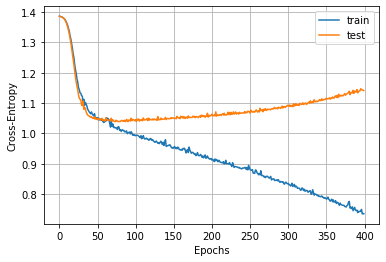

Iteration: 2
288/288 - 0s - loss: 1.1194 - acc: 0.5035
kappa:  0.3379629629629629
f1: 0.5054093567251462
confusion matrix:
 [[37 20 10  5]
 [26 37  8  1]
 [11  5 35 21]
 [ 7  2 27 36]]


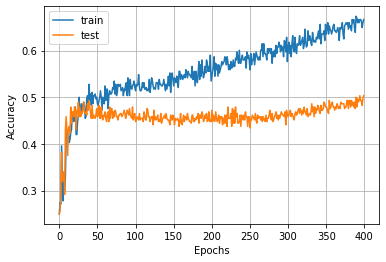

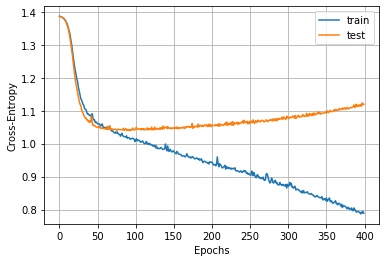


Resultados:
loss: [1.1412309606870015, 1.1193624933560689]
accuracy: [0.48958334, 0.5034722]
kappa: [0.3194444444444444, 0.3379629629629629]
f1: [0.4892857142857142, 0.5054093567251462]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  #model = CNN_3D()
  #model = CNN_3D_BN()
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  model = Conv_LSTM_2D()
  #model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)

  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_23 (ConvLSTM2D) (None, 24, 4, 64)         150016    
_________________________________________________________________
flatten_75 (Flatten)         (None, 6144)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 256)               1573120   
_________________________________________________________________
dense_99 (Dense)             (None, 4)                 1028      
Total params: 1,724,164
Trainable params: 1,724,164
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4965
std: (+/- 0.0069)
Mean Kappa: 0.3287
std: (+/- 0.0093)
Mean F1: 0.4973
Max Accuracy: 0.5035
Max Kappa: 0.3380
Max F1: 0.5054
